In [ ]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

### Load Data

In [ ]:
#file = '/home/yjj/ProcessLocalData/outnpy/LV2415_anodereadout_LV2414_dualreadout_20240821_LED_1.7V_11ns_400_ratio_run.h5'
file = '/home/yjj/ProcessLocalData/outnpy/LV2415_anodereadout_LV2414_dualreadout_20240821_LED_1.7V_10ns_400_ratio_run.h5'
df = pd.read_hdf(file, key='winfo')
df.head()

### Now you can select the data you want to plot histograms 

In [ ]:
area_ch0 = df.Area[ df['Ch']==0]
area_ch1 = df.Area[ df['Ch']==1]

In [ ]:
area_ch0

In [ ]:
np.max(area_ch1)

In [ ]:
#plt.hist(area_ch1, bins=100, range=(0, 20), alpha=0.5, label='Channel 1')
count, bins, *_ = plt.hist(
    area_ch1, bins=np.linspace(-5, 30, 100), 
    histtype='step', lw=1,
    label='Area dynamic width'
    )
plt.xlabel('Area[$10^6  e^-$]')
plt.ylabel('Entries')
plt.yscale('log')
#plt.xlim(-5, 200)
plt.legend()
plt.show()

In [ ]:
count, bins, *_ = plt.hist(
    area_ch0, bins=np.linspace(-5, 150, 100), 
    histtype='step', lw=1,
    label='Area dynamic width'
    )
plt.xlabel('Area[$10^6  e^-$]')
plt.ylabel('Entries')
plt.yscale('log')
#plt.xlim(-5, 200)
plt.legend()
plt.show()

# Try to load numpy data from  multi runs

In [ ]:
def load_runlist_to_numpy(runlist_path):
    with open(runlist_path, 'r') as file:
        runlist = file.readlines()
    runlist = [run.strip() for run in runlist]
    return np.array(runlist)
    
def load_runlist_to_numpy(runlist_path):
    with open(runlist_path, 'r') as file:
        runlist = file.readlines()
    runlist = [run.strip() for run in runlist]
    return np.array(runlist)

runlist = 'runlist/LED_1.7V_10ns_to_15ns_numpy_array'
runs = load_runlist_to_numpy(runlist)
print(runs)

# Load the necessary libraries

In [6]:
import pandas as pd
import numpy as np
import h5py
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#from scipy.optimize import minimize
from scipy import integrate
#from iminuit import Minuit
#from iminuit.cost import UnbinnedNLL
from landaupy import landau
from scipy.optimize import curve_fit



# load data 

In [158]:
#file = 'outnpy/LV2415_anodereadout_LV2414_dualreadout_20240821_LED_1.7V_10ns_400_ratio_run.npy'
file = 'outnpy/LV2415_anodereadout_LV2414_dualreadout_20240821_LED_1.7V_11ns_400_ratio_run.npy'
#file = 'outnpy/LV2415_anodereadout_LV2414_dualreadout_20240821_LED_1.7V_12ns_400_ratio_run.npy'
#file = 'outnpy/LV2415_anodereadout_LV2414_dualreadout_20240821_LED_1.7V_13ns_400_ratio_run.npy'
#file = 'outnpy/LV2415_anodereadout_LV2414_dualreadout_20240821_LED_1.7V_14ns_400_ratio_run.npy'
#file = 'outnpy/LV2415_anodereadout_LV2414_dualreadout_20240821_LED_1.7V_15ns_400_ratio_run.npy'


In [159]:
t_value =file[-22:-18]
v_value = file[-27:-23]
v_value, t_value

('1.7V', '11ns')

In [160]:
winfo = np.load(file)
df = pd.DataFrame(data=winfo, columns=['Ch', 'TTT', 'Baseline', 'Hight', 'Area'])

In [161]:
area_ch0 = df.Area[df.Ch==0 ].astype(np.float64).to_numpy()
area_ch1 = df.Area[df.Ch==1 ].astype(np.float64).to_numpy()

In [162]:
area_ch0, area_ch1

(array([ 790., 1179.,  781., ...,  820.,  939., 1133.]),
 array([  3.,   2.,   3., ...,  82., 112.,   5.]))

In [163]:
ratio = area_ch0/area_ch1

/tmp/ipykernel_487997/2020213250.py:1: RuntimeWarning: divide by zero encountered in divide
  ratio = area_ch0/area_ch1


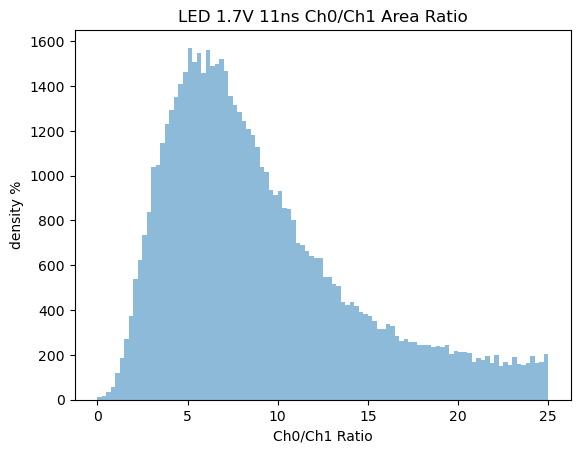

In [165]:
plt.hist(ratio, bins=100, range=(0, 25), density=False, alpha=0.5, label='Ratio')
#plt.yscale('log')
plt.xlabel('Ch0/Ch1 Ratio')
plt.ylabel('density %')
plt.title(r'LED {} {} Ch0/Ch1 Area Ratio'.format(v_value, t_value))
plt.savefig(r'./res/LED_{}_{}_Ch0_Ch1_Ratio.png'.format(v_value, t_value),dpi=300)
plt.show()


In [166]:
area_ch0_pe = area_ch0/82.26
area_ch0_pe

array([ 9.6036956 , 14.33260394,  9.49428641, ...,  9.9683929 ,
       11.41502553, 13.77340141])

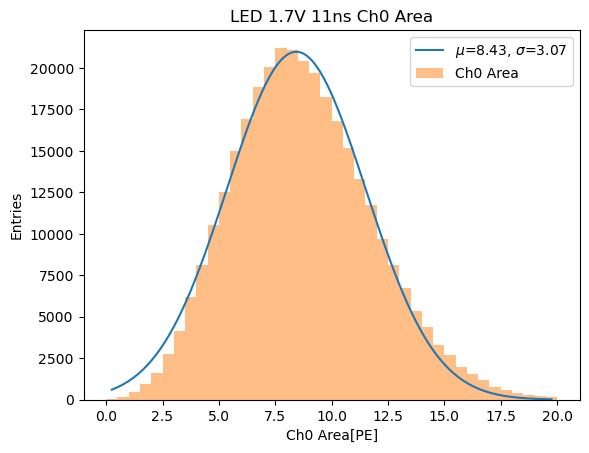

In [172]:
hist, bins_edges = np.histogram(area_ch0_pe,bins=40,range=(0, 20))
bins = (bins_edges[:-1] + bins_edges[1:])/2
def gaussian(x, a, mu, sigma):
    return a * np.exp(-(x - mu)**2 / (2 * sigma**2))
popt, pcov = curve_fit(gaussian, bins, hist, p0=[2.E4, 8, 5])
x_fit = np.linspace(np.min(bins), np.max(bins), 1000)
y_fit = gaussian(x_fit, *popt)
plt.plot(x_fit, y_fit, label=r'$\mu$={:.2f}, $\sigma$={:.2f}'.format(popt[1], popt[2]))
plt.hist(area_ch0_pe, bins=40, range=(0, 20), density=False, alpha=0.5, label='Ch0 Area')
plt.xlabel('Ch0 Area[PE]')
plt.ylabel('Entries')
plt.title(r'LED {} {} Ch0 Area'.format(v_value, t_value))
plt.legend()
plt.savefig(r'./res/LED_{}_{}_Ch0_Area_fit_{:.2f}_PE.png'.format(v_value, t_value,popt[1]),dpi=300)
plt.show()

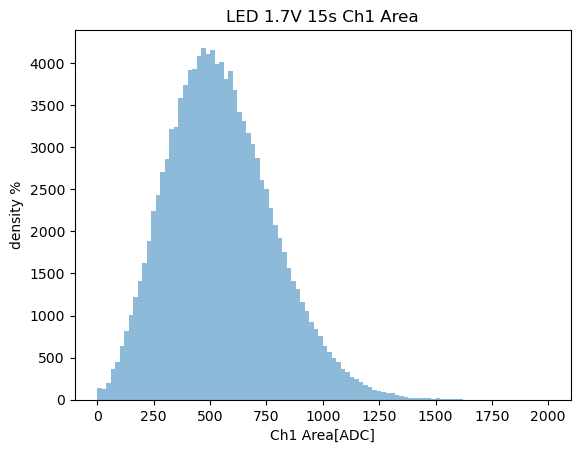

In [46]:
plt.hist(area_ch1, bins=100, range=(0, 2e3), density=False, alpha=0.5, label='Ratio')
plt.xlabel('Ch1 Area[ADC]')
plt.ylabel('density %')
plt.title('LED 1.7V 15s Ch1 Area')
#plt.yscale('log')
plt.show()

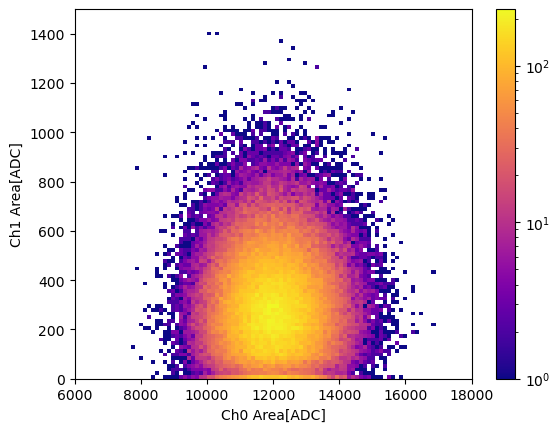

In [96]:
plt.hist2d(area_ch0, area_ch1, bins=[
    np.linspace(6.e3, 1.8e4, 100),
    np.linspace(0, 1500, 100)
] , norm=LogNorm(), cmap='plasma')
plt.colorbar()
#plt.yscale('log')
plt.xlabel('Ch0 Area[ADC]')
plt.ylabel('Ch1 Area[ADC]')
plt.show()

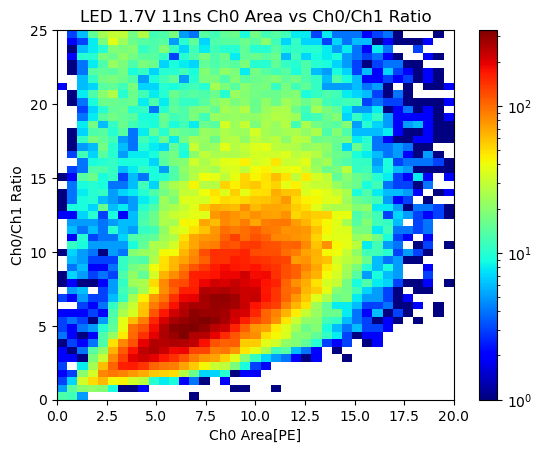

In [174]:
plt.hist2d(area_ch0_pe, ratio, bins=[
    np.linspace(0, 20, 40),
    np.linspace(0, 25, 50)
] , norm=LogNorm(), cmap='jet')
plt.colorbar()
#plt.yscale('log')
plt.xlabel('Ch0 Area[PE]')
plt.ylabel('Ch0/Ch1 Ratio')
plt.title(r'LED {} {} Ch0 Area vs Ch0/Ch1 Ratio'.format(v_value, t_value))
plt.savefig(r'./res/LED_{}_{}_Ch0_Area_vs_Ch0_Ch1_Ratio.png'.format(v_value, t_value),dpi=300)
plt.show()

# Try to fit ratio dsitrubution of two datasets using Landau distribution

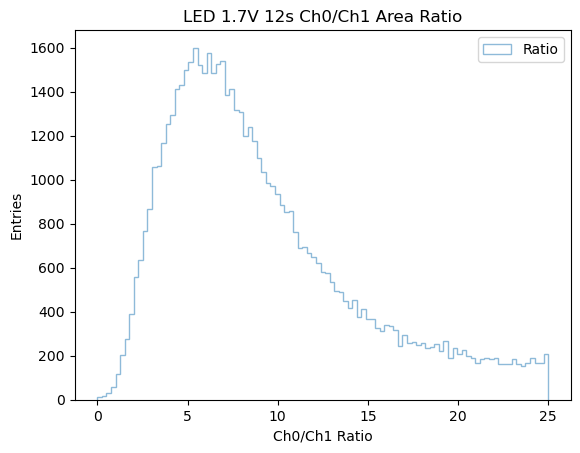

In [176]:
hist, bins_edges, *_ = plt.hist(
    ratio, bins=np.linspace(0, 25, 100), 
    histtype='step', lw=1,
    density=False, alpha=0.5,
    label='Ratio'
    )
plt.xlabel('Ch0/Ch1 Ratio')
plt.ylabel('Entries')
plt.title('LED 1.7V 12s Ch0/Ch1 Area Ratio')
#plt.xlim(-5, 200)
plt.legend()
plt.show()

# define fit function

In [177]:
#from scipy.optimize import minimize
from scipy import integrate
#from iminuit import Minuit
#from iminuit.cost import UnbinnedNLL
from landaupy import landau
from scipy.optimize import curve_fit

def landau_distribution(xdata, mu,sigma, A):
    landau = lambda t, mu, sigma, xdata, A : A*np.exp(-t)*np.cos(t*(xdata -mu)/sigma + 2*t/np.pi *np.log(t/sigma) ) / (sigma *  np.pi)
    integral, error = integrate.quad(landau, 0, np.inf, args=(mu,sigma,xdata, A))
    return integral

def landau_distribution_array(xdata,mu, sigma, A):
    return np.array([landau_distribution(x, mu,sigma, A) for x in xdata])

def landau_fit(xdata, location, scale, A):
    mu = location
    sigma = scale
    return A*landau.pdf(xdata, mu, sigma)


In [178]:
bins = (bins_edges[:-1] + bins_edges[1:])/2
popt, pcov = curve_fit(landau_fit, bins, hist , p0=[5, 3, 1e4])

In [179]:
popt[0], popt[1], popt[2]

(5.539773183512871, 2.0519141727284156, 17656.41853634242)

/tmp/ipykernel_487997/4153390006.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(x_fit, y_fit, 'r-',color='black',  label=r'$\mu$={:.2f}, $\sigma$={:.2f}, A={:.2f}'.format(popt[0],popt[1],popt[2]))


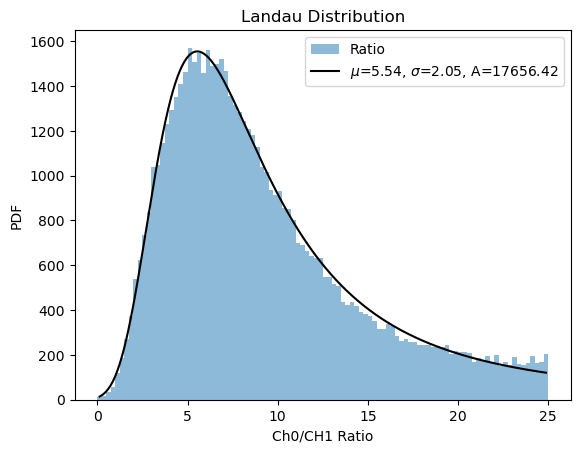

In [180]:
x_fit = np.linspace(np.min(bins), np.max(bins), 1000)
y_fit = landau_fit(x_fit, popt[0], popt[1],popt[2])
fig, ax = plt.subplots()
ax.hist(ratio, bins=100, range=(0, 25), density=False, alpha=0.5, label='Ratio')
ax.plot(x_fit, y_fit, 'r-',color='black',  label=r'$\mu$={:.2f}, $\sigma$={:.2f}, A={:.2f}'.format(popt[0],popt[1],popt[2]))
ax.set_xlabel('Ch0/CH1 Ratio')
ax.set_ylabel('PDF')
ax.set_title('Landau Distribution')
ax.legend()
plt.savefig(r'./res/LED_{}_{}_Ch0_CH1_Ratio_fit_mu_{:.2f}_sigma_{:.2f}.png'.format(v_value,t_value,popt[0],popt[1] ),dpi=300)
plt.show()